In [84]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
# Create a Spark session

In [86]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ChicagoCrimeAnalysis").getOrCreate()


In [87]:
# Define the schema for loading the Chicago crime dataset

In [88]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType

Schema_Name = StructType([
    StructField("ID", IntegerType(), True),
    StructField("CaseNumber", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("PrimaryType", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("LocationDescription", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", IntegerType(), True),
    StructField("District", IntegerType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("CommunityArea", IntegerType(), True),
    StructField("FBICode", StringType(), True),
    StructField("XCoordinate", FloatType(), True),
    StructField("YCoordinate", FloatType(), True),
    StructField("Year", IntegerType(), True),
    StructField("UpdatedOn", TimestampType(), True),
    StructField("Latitude", FloatType(), True),
    StructField("Longitude", FloatType(), True),
    StructField("Location", StringType(), True)
])


In [89]:
# Load the Chicago crime data
dataDF = spark.read.format("csv") \
    .option("header", "true") \
    .option("delimiter", ",") \
    .schema(Schema_Name) \
    .load("Crimes_-_2001_to_Present.csv")

dataDF.show()

+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude| Longitude|            Location|
+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|10224738|  HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|       9|  12|           61|    08B|  1165074.

In [90]:
# Clean the data:
     # a)Remove all null values.
     # b)Change 'Date' column data type

In [91]:
from pyspark.sql.functions import *

# Remove all null values
df = dataDF.fillna({
    "PrimaryType": "Other",
    "Description": "No description available"
})
df.show()

+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|      ID|CaseNumber|                Date|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude| Longitude|            Location|
+--------+----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|10224738|  HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|       9|  12|           61|    08B|  1165074.

In [92]:
# Change 'Date' column data type
df = df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = false)
 |-- Description: string (nullable = false)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- CommunityArea: integer (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: float (nullable = true)
 |-- YCoordinate: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: timestamp (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Location: string (nullable = true)



In [93]:
# Filter the data for last ten years
df = df.filter(col("Year") >= 2013)
df.show()

+--------+----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|      ID|CaseNumber|               Date|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn| Latitude| Longitude|            Location|
+--------+----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+---------+----------+--------------------+
|10224738|  HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|       9|  12|           61|    08B|  1165074.0|  

In [94]:
# Remove all the records with the following crime types
df = df.filter(col("PrimaryType").isin([
    "NON-CRIMINAL (SUBJECT SPECIFIED)",
    "OTHER OFFENSE",
    "STALKING",
    "NON - CRIMINAL",
    "ARSON"
]) == False)

In [95]:
# Merge the similar crime types
dataDF = dataDF.withColumn("PrimaryType", when(col("PrimaryType").isin(["SEX OFFENSE", "PROSTITUTION"]), "SEX OFFENSE/PROSTITUTION").otherwise(col("PrimaryType")))

In [96]:
# Analyze the data and present results:
# Show year-wise trend of the crime for last ten years.
yearwise_crime = df.groupBy("Year").count().orderBy("Year")
yearwise_crime.show()


+----+------+
|Year| count|
+----+------+
|2013|   617|
|2014|  1345|
|2015|147948|
|2016|244138|
|2017|243680|
|2018|243458|
|2019|104583|
|2020| 16104|
|2021|  2349|
|2022|  1219|
+----+------+



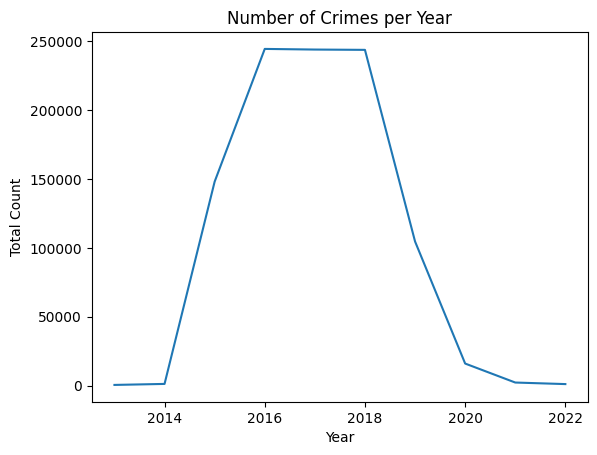

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by Year and count the number of occurrences
yearwise_crime = df.groupBy("Year").count().orderBy("Year")

# Convert to Pandas DataFrame for plotting
yearwise_crime_df = yearwise_crime.toPandas()

# Plot the line chart
sns.lineplot(x="Year", y="count", data=yearwise_crime_df)
plt.xlabel("Year")
plt.ylabel("Total Count")
plt.title("Number of Crimes per Year")
plt.show()


In [98]:
# Find out at which hour of the day crime is highest.
hourwise_crime = df.groupBy(hour(col("Date")).alias("hour")).count().orderBy(desc("count"))
hourwise_crime.show(1)


+----+-----+
|hour|count|
+----+-----+
|  12|59681|
+----+-----+
only showing top 1 row



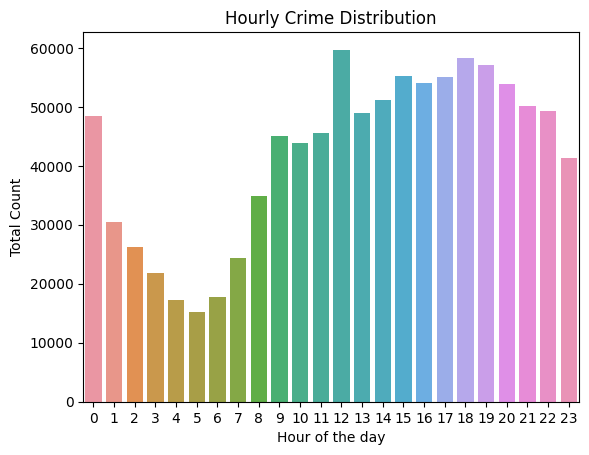

In [99]:
# Convert the Spark DataFrame to a Pandas DataFrame
hourwise_crime_df = hourwise_crime.toPandas()

# Plot the data using Seaborn
sns.barplot(x="hour", y="count", data=hourwise_crime_df)
plt.xlabel("Hour of the day")
plt.ylabel("Total Count")
plt.title("Hourly Crime Distribution")
plt.show()


In [101]:
# Find top ten crimes and present them as a bar chart.
from pyspark.sql.functions import desc

# Group by Primary Type and count the number of occurrences
topten_crimes = df.groupBy("PrimaryType").count().orderBy(desc("count")).limit(10)

# Convert to Pandas DataFrame for plotting
topten_crimes_df = topten_crimes.toPandas()

topten_crimes_df




,PrimaryType,count
0,THEFT,251164
1,BATTERY,201511
2,CRIMINAL DAMAGE,119584
3,ASSAULT,77782
4,DECEPTIVE PRACTICE,75620
5,NARCOTICS,57278
6,BURGLARY,51962
7,MOTOR VEHICLE THEFT,43496
8,ROBBERY,42991
9,CRIMINAL TRESPASS,27078


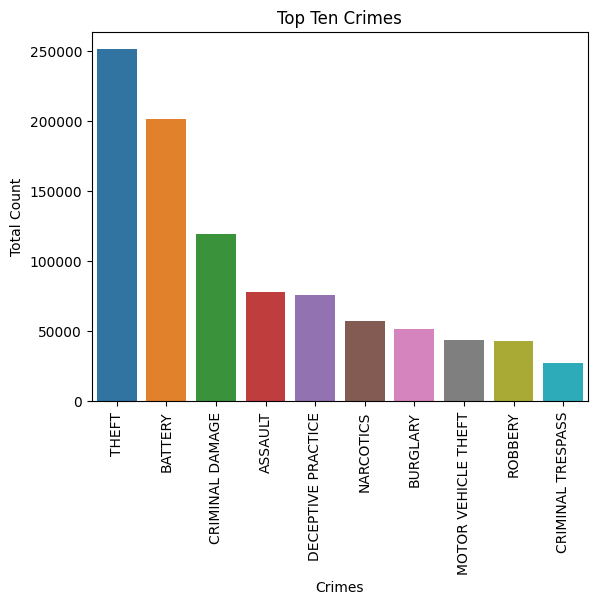

In [103]:
# Plot the bar chart using Seaborn
sns.barplot(x="PrimaryType", y="count", data=topten_crimes_df)
plt.xticks(rotation=90)
plt.xlabel("Crimes")
plt.ylabel("Total Count")
plt.title("Top Ten Crimes")
plt.show()